In [1]:
!sudo apt-get install -y fonts-nanum* | tail -n 1
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib
!pip install torchviz | tail -n 1

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 4.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 39 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no suc

In [1]:
# 라이브러리 임포트

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# 폰트 관련 용도
import matplotlib.font_manager as fm

# Colab, Linux
# 나눔 고딕 폰트의 경로 명시
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()

# Window
# font_name = "NanumBarunGothic"

# Mac
# font_name = "AppleGothic"

In [2]:
# 기본 폰트 설정
plt.rcParams['font.family'] = font_name

# 기본 폰트 사이즈 변경
plt.rcParams['font.size'] = 14

# 기본 그래프 사이즈 변경
plt.rcParams['figure.figsize'] = (6,6)

# 기본 그리드 표시
# 필요에 따라 설정할 때는, plt.grid()
plt.rcParams['axes.grid'] = True
plt.rcParams["grid.linestyle"] = ":"

# 마이너스 기호 정상 출력
plt.rcParams['axes.unicode_minus'] = False

# 넘파이 부동소수점 자릿수 표시
np.set_printoptions(suppress=True, precision=4)

In [3]:
# warning 표시 끄기
import warnings
warnings.simplefilter('ignore')

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torchviz import make_dot

### 이진분류

#### 문제 정의하기

붓꽃 데이터셋을 이용한 분류하기를 연습한다.
두 종류의 꽃을 가지고 분류를 하고 '이진 로지스틱 회귀 모델'을 알아본다.

(이름에 회귀 모델이라고 붙었지만 결국은 분류 모델임)

#### 주요 개념

*   분류 모델은 '정확도'라는 지표를 사용하여 성능 판단.
*   과학습 (Overfitting)을 지양해야함



#### 과학습 (Overfitting)

학습을 너무 많이 진행할 수록 오히려 검증 데이터의 정확도가 떨어지는 경우가 생김. 아래의 사진처럼 너무 과하게 트레이닝 데이터셋에 맞추기 보단 적당한 선에서 모델을 학습시키는 것이 중요

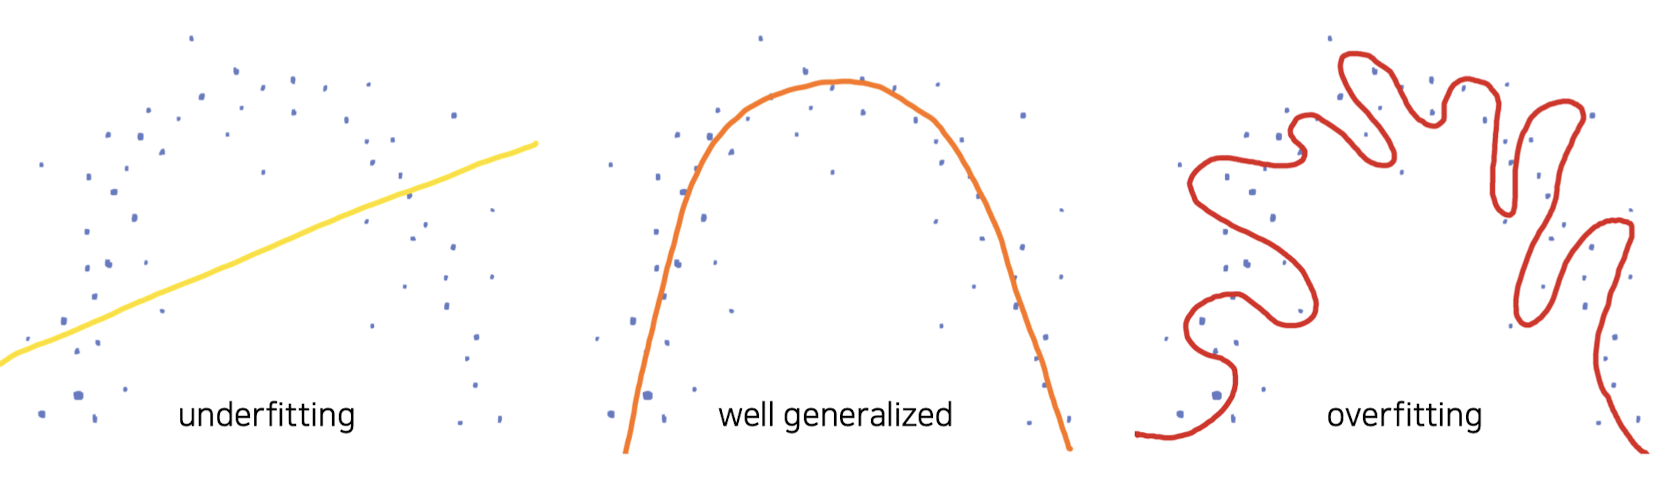

#### 시그모이드 함수

이진 분류에서 사용하는 예측함수.
시그모이드 함수를 사용하는 이유는 함수 값을 확률로 해석하기 위함이다.


*   항상 값이 증가함
*   0과 1사이의 값을 취함
*   x=0 -> 0.5
*   그래프가 (0, 0.5) 기준 대칭

분류 모델에서는 값이 0.5 이상일경우 예측 결과가 1, 0.5보다 작은 경우 예측결과를 0으로 해석할 수 있다.

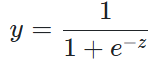

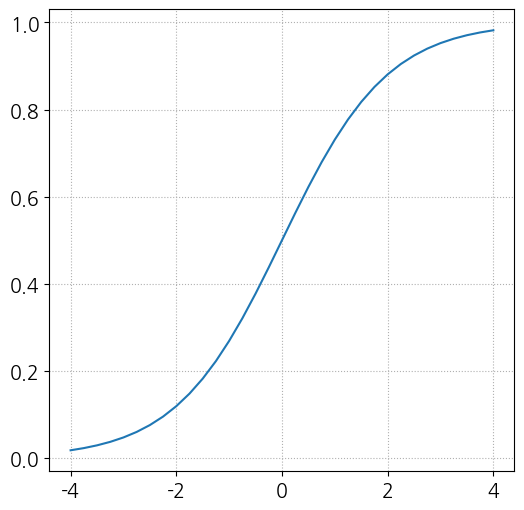

In [5]:
x_np = np.arange(-4,4.1,0.25)
x = torch.tensor(x_np).float()
y = torch.sigmoid(x)

plt.plot(x.data, y.data)
plt.show()

#### 교차 엔트로피 함수

이진 분류에서 사용하는 손실함수

앞서 알아본 시그모이드 함수로 얻은 출력값은 '입력 데이터에 대해 분류 결과가 1이될 확률'을 말함. 이진 분류는 정답이 1 또는 0 이므로
- 분류 결과가 1이될 확률이 f(u)
- 분류 결과가 0이될 확률이 1 - f(u)

  (여기서 f()는 시그모이드를 거치고 나온 값을 말함)


정답값 yt 값이 [1, 0, 0, 1, 0] 일 경우엔
모델의 확신도(분류의 값이 정답일 확률)은 다음과 같다
f(u1), 1 - f(u2), 1 - f(u3), f(u4), 1 - f(u5)

여기서 손실 함수에 최우 추정이라는 개념을 사용함. 모든 데이터에 대해 확신도를 곱한 결과를 최대로 하는 파라미터가 가장 그럴듯하다고 판단하는 방법이다.

f(u1) * ( 1 - f(u2) ) *  ( 1 - f(u3) ) *  f(u4) * ( 1 - f(u5)  )

해당 식에 log를 씌우게 되면 곱들을 합으로 계산할 수 있게 됨.

이를 정리할 경우

yt * log(f(u)) + (1 - yt) * log (1 - f(u))

이 값을 최소가 되는 쪽으로 손실함수를 작성해야 하므로 앞에 (-)값을 붙이면 된다.

따라서 모든 값의 총 합의 음수 값을 최소화하는 방향으로 손실함수를 작성한다.

#### 이진 분류 실습

In [6]:
from sklearn.datasets import load_iris

iris = load_iris()

# 입력 데이터와 정답 데이터
x_org , y_org = iris.data, iris.target

In [7]:
# 붓꽃 데이터셋은 150행이지만 100행까지 정답이 setosa와 versicolor로 한정됨. x의 열 방향도 첫 2열(sepal의 길이와 폭만 사용)
x_data = iris.data[:100, :2]
y_data = iris.target[:100]

In [8]:
# 훈련 데이터와 검증 데이터 분할

print(x_data.shape, y_data.shape)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=70, test_size=30, random_state = 123)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(100, 2) (100,)
(70, 2) (30, 2) (70,) (30,)


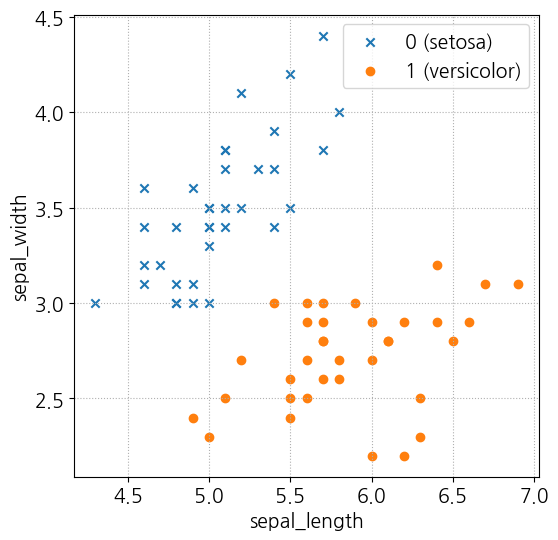

In [9]:
# 산포도 출력

x_t0 = x_train[y_train==0]
x_t1 = x_train[y_train==1]
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x', label='0 (setosa)')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o', label='1 (versicolor)')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()

In [10]:
# 모델 정의

# 입력 차원 수
n_input = x_train.shape[1]

# 출력 차원 수
n_output = 1

class Net(nn.Module):
  def __init__(self, n_input, n_output):
    super().__init__()
    self.l1 = nn.Linear(n_input, n_output)
    self.sigmoid = nn.Sigmoid()
    self.l1.weight.data.fill_(1.0)
    self.l1.bias.data.fill_(1.0)

  def forward(self,x):
    x1 = self.l1(x)
    x2 = self.sigmoid(x1)
    return x2

In [11]:
net = Net(n_input, n_output)

# 최적화 알고리즘과 손실 함수의 정의
criterion = nn.BCELoss()

# 학습률
lr = 0.01

# 최적화 함수 : 경사 하강법
optimizer = optim.SGD(net.parameters(), lr=lr)

In [12]:
# 입력 데이터와 출력 데이터 텐서로 변환

inputs = torch.tensor(x_train).float()
labels = torch.tensor(y_train).float()

labels1 = labels.view((-1,1))

inputs_test = torch.tensor(x_test).float()
labels_test = torch.tensor(y_test).float()

labels1_test = labels_test.view((-1,1))


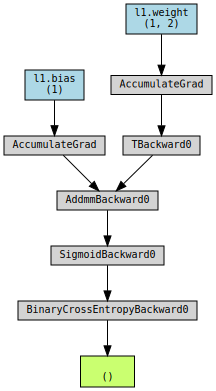

In [13]:
# 손실 계산 그래프 출력
outputs = net(inputs)
loss = criterion(outputs, labels1)

g = make_dot(loss, params=dict(net.named_parameters()))
display(g)


In [14]:
# 반복 계산의 초기화 처리 정리

lr = 0.01
net = Net(n_input, n_output)
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
num_epochs = 10000

In [15]:
history = np.zeros((0,5))   # 반복횟수 / 훈련 데이터의 loss값 / 훈련 정확도 / 검증 데이터의 loss값  / 검증 정확도

for epoch in range(num_epochs):
  # 훈련 페이즈



  # 경사값 초기화
  optimizer.zero_grad()

  # 예측 계산
  outputs = net(inputs)

  # 손실 계산
  loss = criterion(outputs, labels1)

  # 경사 계산
  loss.backward()

  # 파라미터 수정
  optimizer.step()

  # 손실 저장
  train_loss = loss.item()

  # 예측 라벨 계산
  predicted = torch.where(outputs<0.5, 0,1)

  # 정확도 계산
  train_acc = (predicted == labels1).sum() / len(y_train)



  # 예측 페이즈



  # 예측 계산
  outputs_test = net(inputs_test)

  # 손실 계산
  loss_test = criterion(outputs_test, labels1_test)

  # 손실 저장
  val_loss = loss_test.item()

  # 예측 라벨 계산
  predicted_test = torch.where(outputs_test<0.5, 0,1)

  # 정확도 계산
  val_acc = (predicted_test == labels1_test).sum() / len(y_test)

  if (epoch % 10 ==0):
    print(f'Epoch : {epoch}, loss : {train_loss:.5f}, acc : {train_acc:.5f}, val_loss : {val_loss:.5f}, val_acc : {val_acc:.5f}')
    item = np.array([epoch, train_loss, train_acc, val_loss, val_acc])
    history = np.vstack((history, item))

Epoch : 0, loss : 4.77289, acc : 0.50000, val_loss : 4.49384, val_acc : 0.50000
Epoch : 10, loss : 3.80546, acc : 0.50000, val_loss : 3.56537, val_acc : 0.50000
Epoch : 20, loss : 2.84329, acc : 0.50000, val_loss : 2.64328, val_acc : 0.50000
Epoch : 30, loss : 1.91613, acc : 0.50000, val_loss : 1.76244, val_acc : 0.50000
Epoch : 40, loss : 1.17137, acc : 0.50000, val_loss : 1.08537, val_acc : 0.50000
Epoch : 50, loss : 0.84140, acc : 0.50000, val_loss : 0.81872, val_acc : 0.50000
Epoch : 60, loss : 0.77087, acc : 0.50000, val_loss : 0.77093, val_acc : 0.50000
Epoch : 70, loss : 0.75450, acc : 0.34286, val_loss : 0.76105, val_acc : 0.33333
Epoch : 80, loss : 0.74542, acc : 0.25714, val_loss : 0.75447, val_acc : 0.20000
Epoch : 90, loss : 0.73734, acc : 0.24286, val_loss : 0.74778, val_acc : 0.16667
Epoch : 100, loss : 0.72949, acc : 0.24286, val_loss : 0.74098, val_acc : 0.13333
Epoch : 110, loss : 0.72180, acc : 0.27143, val_loss : 0.73419, val_acc : 0.16667
Epoch : 120, loss : 0.71423

#### 결과 확인

In [16]:
print(f'초기 상태 : 손실 : {history[0,3]:.5f}  정확도 : {history[0,4]:.5f}' )
print(f'최종 상태 : 손실 : {history[-1,3]:.5f}  정확도 : {history[-1,4]:.5f}' )

초기 상태 : 손실 : 4.49384  정확도 : 0.50000
최종 상태 : 손실 : 0.15395  정확도 : 0.96667


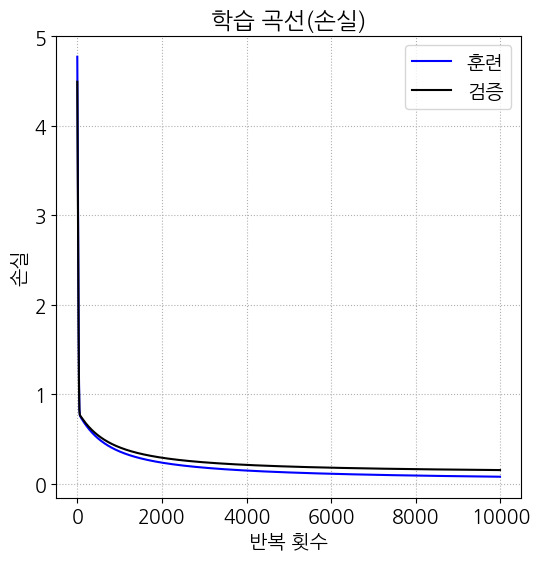

In [17]:
plt.plot(history[:,0], history[:,1], 'b', label='훈련')
plt.plot(history[:,0], history[:,3], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('손실')
plt.title('학습 곡선(손실)')
plt.legend()
plt.show()

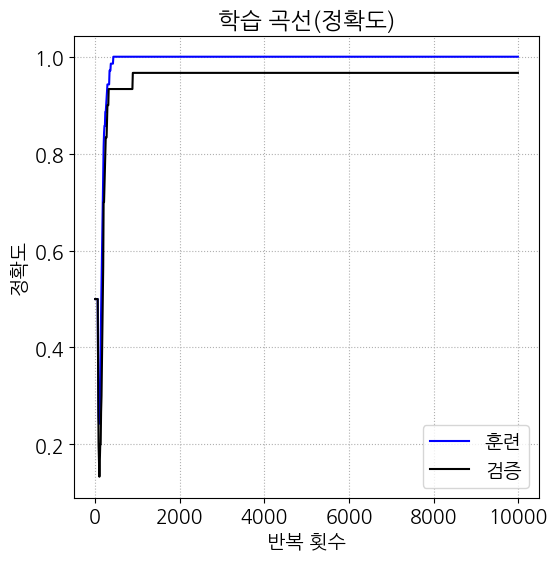

In [18]:
plt.plot(history[:,0], history[:,2], 'b', label='훈련')
plt.plot(history[:,0], history[:,4], 'k', label='검증')
plt.xlabel('반복 횟수')
plt.ylabel('정확도')
plt.title('학습 곡선(정확도)')
plt.legend()
plt.show()

In [20]:
# 검증 데이터 준비

x_t0 = x_test[y_test==0]
x_t1 = x_test[y_test==1]

In [21]:
# 파라미터 취득
bias = net.l1.bias.data.numpy()
weight = net.l1.weight.data.numpy()
print(f'BIAS = {bias}, WEIGHT = {weight}')

# 결정 경계를 그리기 위해 x1로부터 x2를 계산
def decision(x):
    return(-(bias + weight[0,0] * x)/ weight[0,1])

# 산포도의 x1의 최솟값과 최댓값
xl = np.array([x_test[:,0].min(), x_test[:,0].max()])
yl = decision(xl)

# 결과 확인
print(f'xl = {xl}  yl = {yl}')

BIAS = [0.3386], WEIGHT = [[ 2.97 -5.3 ]]
xl = [4.4 7. ]  yl = [2.5296 3.9866]


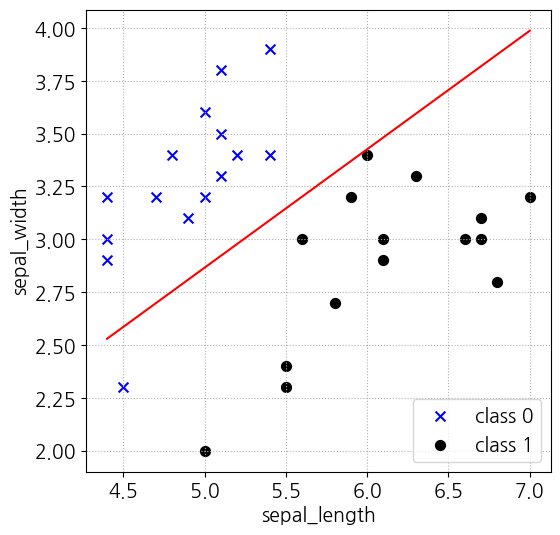

In [22]:
# 산포도 출력
plt.scatter(x_t0[:,0], x_t0[:,1], marker='x',
        c='b', s=50, label='class 0')
plt.scatter(x_t1[:,0], x_t1[:,1], marker='o',
        c='k', s=50, label='class 1')

# 결정 경계 직선
plt.plot(xl, yl, c='r')
plt.xlabel('sepal_length')
plt.ylabel('sepal_width')
plt.legend()
plt.show()